<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/mainJacob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial version

In [1]:
!pip install datasets
!pip install transformers
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.9 MB/s eta 0:00

In [2]:
# Modules to be loaded and used
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch import nn
import math
from functools import partial
from pathlib import Path
from tqdm import tqdm
import rich
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

from __future__ import division
from __future__ import print_function

import numpy as np
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint
import re


from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


# (a) Function approximation
## 1D

Compiling model...
Building feed-forward neural network...
'build' took 0.214078 s

'compile' took 1.192675 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.02e-01]    [5.42e-01]    [1.03e+00]    
1000      [5.70e-06]    [1.40e-01]    [5.26e-01]    
2000      [1.18e-06]    [1.38e-01]    [5.22e-01]    
3000      [5.93e-07]    [1.39e-01]    [5.23e-01]    
4000      [1.68e-06]    [1.40e-01]    [5.25e-01]    
5000      [5.75e-12]    [1.40e-01]    [5.25e-01]    
6000      [7.27e-14]    [1.41e-01]    [5.27e-01]    
7000      [2.38e-06]    [1.41e-01]    [5.28e-01]    
8000      [6.11e-10]    [1.42e-01]    [5.28e-01]    
9000      [3.57e-09]    [1.41e-01]    [5.27e-01]    
10000     [6.62e-15]    [1.42e-01]    [5.29e-01]    

Best model at step 10000:
  train loss: 6.62e-15
  test loss: 1.42e-01
  test metric: [5.29e-01]

'train' took 10.122826 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data 

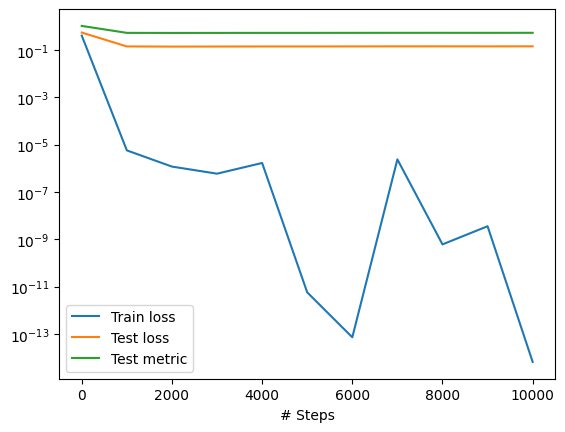

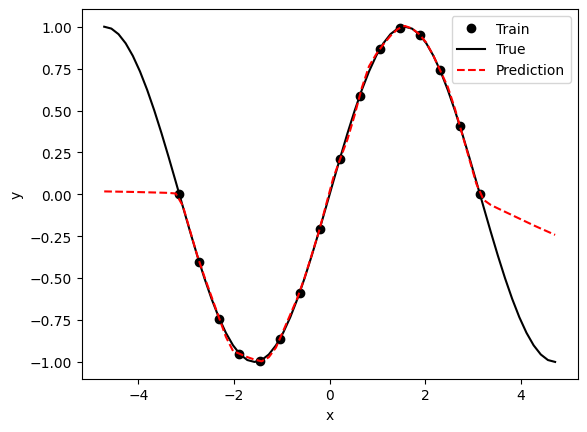

In [80]:
n = 16
a = 1
b = 5
c = 1
N = np.pi
X  = np.linspace(-N,N,n)
#y  = a*X**3 + b*X**2 + c*X
y = np.sin(X)

Xtest = np.linspace(-1.5*N,1.5*N,4*n)
#ytest = a*Xtest**3 + b*Xtest**2 + c*Xtest
ytest = np.sin(Xtest)

# function approximation, test outside parameter domain
data2 = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=np.reshape(y, (-1, 1)),
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=np.reshape(ytest, (-1, 1)),
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + 3*[20] + [1]
activation = "relu"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data2, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


## 2D

Compiling model...
Building feed-forward neural network...
'build' took 0.066641 s

'compile' took 0.438652 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.80e-01]    [5.58e-01]    [1.06e+00]    
1000      [5.29e-03]    [3.73e-01]    [8.64e-01]    
2000      [7.00e-04]    [1.16e-01]    [4.81e-01]    
3000      [5.02e-04]    [9.49e-02]    [4.36e-01]    
4000      [3.79e-04]    [8.81e-02]    [4.20e-01]    
5000      [3.35e-04]    [8.43e-02]    [4.11e-01]    

Best model at step 5000:
  train loss: 3.35e-04
  test loss: 8.43e-02
  test metric: [4.11e-01]

'train' took 6.266793 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


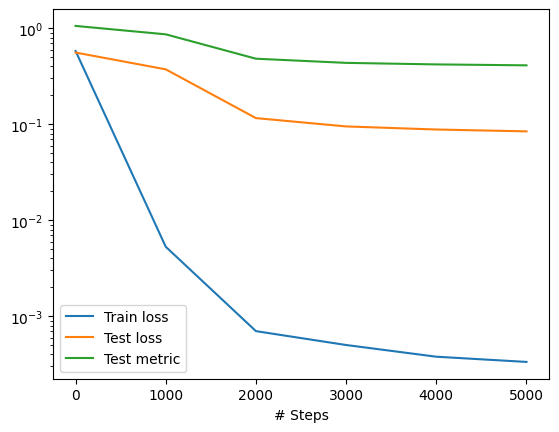

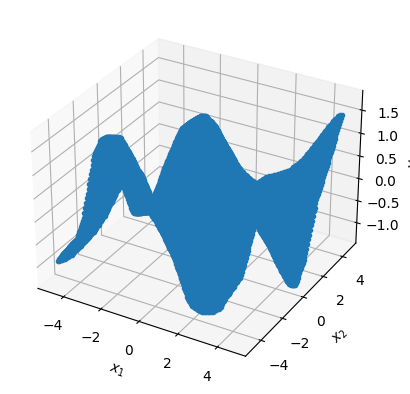

In [68]:
n = 30
N = np.pi

# the function that I'm going to plot
def y_func(X1,X2):
 return np.sin(X1+X2)

x1 = np.linspace(-N,N,n)
x2 = x1

X1,X2 = meshgrid(x1, x2) # grid of point
y = y_func(X1, X2) # evaluation of the function on the grid

x1test = np.linspace(-1.5*N,1.5*N,4*n)
x2test = x1test

X1test,X2test = meshgrid(x1test, x2test) # grid of point
ytest = y_func(X1test, X2test) # evaluation of the function on the grid


# function approximation, test outside parameter domain
data2D = dde.data.DataSet(
    X_train = np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )),
    y_train = np.reshape(y, (-1, 1)),
    X_test = np.hstack(( np.reshape(X1test, (-1, 1)),np.reshape(X2test, (-1, 1)) )),
    y_test = np.reshape(ytest, (-1, 1)),
    col_x = (0,),
    col_y = (1,),
)

layer_size = [2] + [20] * 3 + [1]
activation = "relu"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data2D, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# (b)

Compiling model...
Building feed-forward neural network...
'build' took 0.072903 s

'compile' took 0.587019 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.08e+00]    [2.10e+00]    [2.07e+00]    
1000      [1.81e-03]    [1.55e-03]    [5.61e-02]    
2000      [3.29e-05]    [2.67e-05]    [7.36e-03]    
3000      [1.01e-05]    [8.59e-06]    [4.18e-03]    
4000      [6.22e-06]    [5.50e-06]    [3.34e-03]    
5000      [1.08e-05]    [1.06e-05]    [4.64e-03]    

Best model at step 4000:
  train loss: 6.22e-06
  test loss: 5.50e-06
  test metric: [3.34e-03]

'train' took 5.565538 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


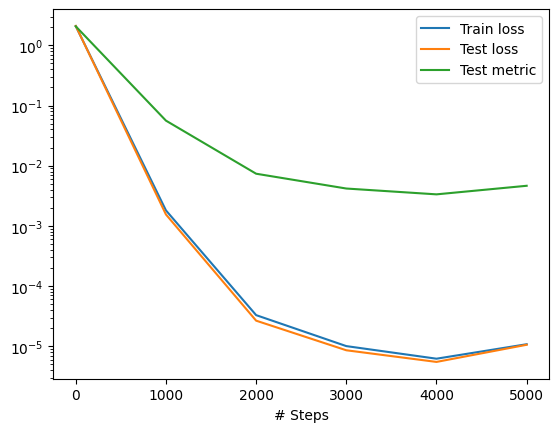

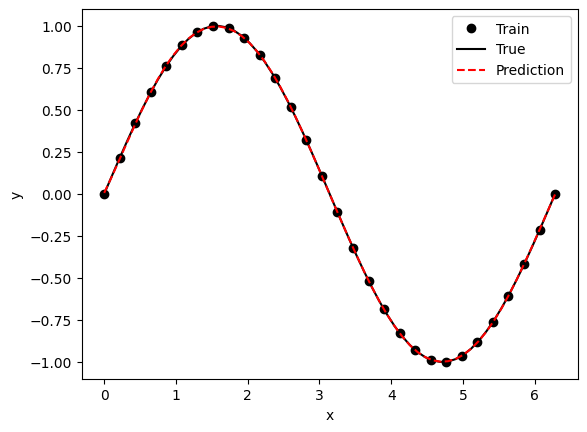

In [73]:
X = np.linspace(0,2*np.pi,30)
y = np.sin(X)
Xtest = np.linspace(0,2*np.pi,2*30)
ytest = np.sin(Xtest)
# function approximation, test outside parameter domain
data2 = dde.data.DataSet(
X_train=np.reshape(X, (-1, 1)),
y_train=np.reshape(y, (-1, 1)),
X_test=np.reshape(Xtest, (-1, 1)),
y_test=np.reshape(ytest, (-1, 1)),
col_x=(0,),
col_y=(1,),
)
layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)
model = dde.Model(data2, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

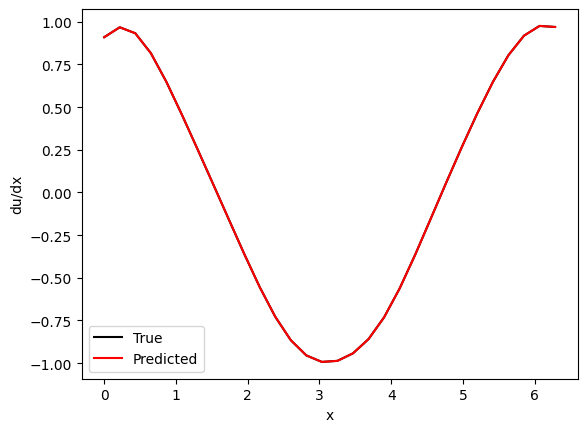

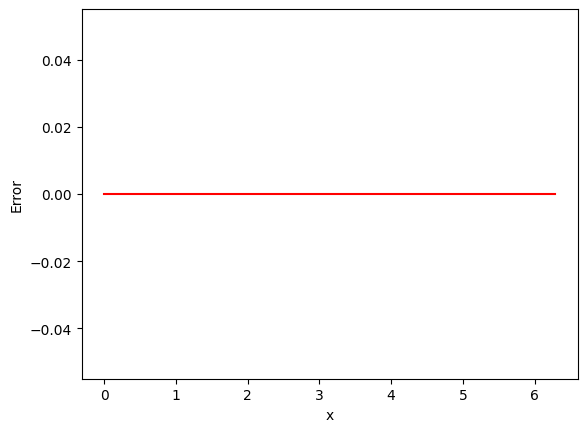

In [77]:
# compute gradient of solution
def dudx(x, u):
  return dde.grad.jacobian(u, x, i=0)

du_dx = model.predict(np.reshape(X, (-1, 1)), operator=dudx)

yx = du_dx

plt.figure()
plt.plot(X,yx,'k',label='True')
plt.plot(np.reshape(X, (-1, 1)),du_dx,'r',label='Predicted')
plt.xlabel('x')
plt.ylabel('du/dx')
plt.legend()
plt.show()

plt.figure()
plt.plot(X,du_dx-np.reshape(yx,(-1,1)),'r')
plt.xlabel('x')
plt.ylabel('Error')
plt.show()

# (c)

Compiling model...
Building feed-forward neural network...
'build' took 0.113128 s

'compile' took 0.830685 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [8.73e+10]    [8.57e+11]    [1.00e+00]    
1000      [1.91e+10]    [4.45e+11]    [7.21e-01]    
2000      [1.39e+10]    [3.43e+11]    [6.33e-01]    
3000      [1.38e+10]    [3.41e+11]    [6.31e-01]    
4000      [1.36e+10]    [3.39e+11]    [6.29e-01]    
5000      [1.34e+10]    [3.38e+11]    [6.28e-01]    
6000      [1.32e+10]    [3.36e+11]    [6.26e-01]    
7000      [1.29e+10]    [3.33e+11]    [6.23e-01]    
8000      [1.16e+10]    [3.22e+11]    [6.13e-01]    
9000      [7.39e+09]    [2.78e+11]    [5.70e-01]    
10000     [2.91e+09]    [2.10e+11]    [4.95e-01]    

Best model at step 10000:
  train loss: 2.91e+09
  test loss: 2.10e+11
  test metric: [4.95e-01]

'train' took 11.695100 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data 

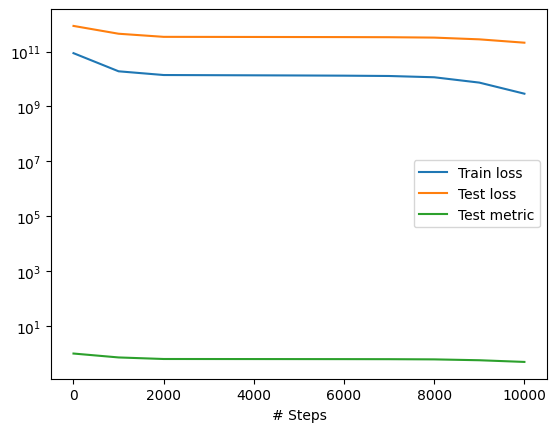

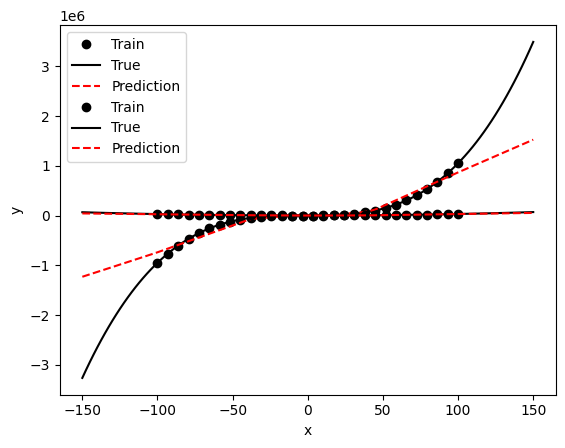

In [70]:
a = 1
b = 5
c = 1
X  = np.linspace(-100,100,n)
y  = [a*X**3 + b*X**2 + c*X, 3*a*X**2 + 2*b*X + c]
#y = np.sin(X)

Xtest  = np.linspace(-150,150,4*n)
ytest  = [a*Xtest**3 + b*Xtest**2 + c*Xtest, 3*a*Xtest**2 + 2*b*Xtest + c]
#ytest = np.sin(X)

# reshaping output training data
y1 = np.asmatrix(y[0]).transpose()
y2 = np.asmatrix(y[1]).transpose()
ynew = np.concatenate((y1,y2),axis=1)
ynew = np.asarray(ynew)

# reshaping output test data
ytest1 = np.asmatrix(ytest[0]).transpose()
ytest2 = np.asmatrix(ytest[1]).transpose()
ytestnew = np.concatenate((ytest1,ytest2),axis=1)
ytestnew = np.asarray(ytestnew)


# function approximation, test outside parameter domain
data2 = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=ynew,
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=ytestnew,
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + [20] * 3 + [2]
activation = "relu"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data2, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)